# **Understanding People Faces with Data Science**
**OpenU Data Science Project**

Rafael Balaish - 308071059

Oded Gottesman - 313134553

## **Goal**

Our goal in this project is to detect age and gender of a person from a picture of his/hers face. We are going to use neural networks in order to train our model to classify age and gender. This application may help for targeting untagged profile pictures for advertising purposes, detect potential clients in malls, security cameras automatic alerts, and these are only a few examples for possible uses.

**Our stretch goal** is to identify a person's emotion by the look on his/hers face. This label can be be useful for marketing (figuring out if the customer is happy during the visit), and also security industries.

**DataSets**

We are going to use [UTKFace](https://susanqq.github.io/UTKFace/) & [FairFace](https://github.com/joojs/fairface) datasets for age and gender classification. We are going to use the "aligned & cropped Faces" dataset.

The third dataset we are going to use for emotion detection is [Facial Expression Recognition(FER)Challenge](https://www.kaggle.com/ashishpatel26/facial-expression-recognitionferchallenge?)



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
#all imports needed for this notebook and configuration
import fastai
import fastai.vision as fav
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import pandas as pd
import IPython
import seaborn as sns
from PIL import Image

np.random.seed(42)

# Exploring UTKFace Dataset
The photos are labeled in their names in the following way:
*age_gender_race_datetime*

**Age** - an integer from **1** to **116**, indicating the actual age of the person in the photo.

**Gender** - either 0 or 1. **0** stands for **male**, **1** stands for **female**.

**Race** - an integer between 0 and 4.
  **0** - White
  **1** - Black
  **2** - Asian
  **3** - Indian
  **4** - Other (such as Hispanic, Latino, Middle Eastern...)

**Date & Time** - the date and time the image was collected to the UTKFace dataset, presented in the next format: *yyyymmddHHMMSSFFF*

## Loading Data

In [ ]:
shutil.unpack_archive('/content/gdrive/My Drive/Colab_Notebooks/UTKFace-clean.zip', '/tmp/UTKFace_dataset_clean')
os.chdir( '/tmp/UTKFace_dataset_clean')


## Clean the data

1. We found that there are **3** images with wrong name convention (missing labels), so we ignore those samples (can be seen in the catch clause in the next code cell).

2. During the process of training our model, we saw that there are wrong age labeled examples. So we went over them manually, and removed those photos, then reloaded our clean dataset. Because we don't know the actual age, we removed only the extreme obvious wrong sample, e.g. a baby that was labeled as 80 year old...
During this stage we removed **39** samples.

** After we went over all the samples manually, we must confess that it's not an easy mission, we could not classify all samples correctly :)





In [ ]:
path = "/tmp/UTKFace_dataset_clean/UTKFace/"
files = os.listdir(path)
size = len(files)

print("Example for a file name:", files[0])
print("Total samples:", size)

AGE_INDEX = 0
GENDER_INDEX = 1
RACE_INDEX = 2

images = []
ages = []
genders = []
races = []

for filename in files:
    try: 
      split_var = filename.split('_')
      races.append(int(split_var[RACE_INDEX]))
      ages.append(int(split_var[AGE_INDEX]))
      genders.append(int(split_var[GENDER_INDEX]))

    except ValueError:
      #ignore missing race label (clean data)
      os.remove(path+filename)
      continue    

Example for a file name: 3_1_0_20170109193421750.jpg.chip.jpg
Total samples: 23669


**Wrong label examples**


<img src="https://i.ibb.co/2dyWG9k/dataset-wrong-labels.png" alt="dataset-wrong-labels" border="0">

## Looking at the distribution of ages in our dataset samples

Max age: 116
Min age: 1


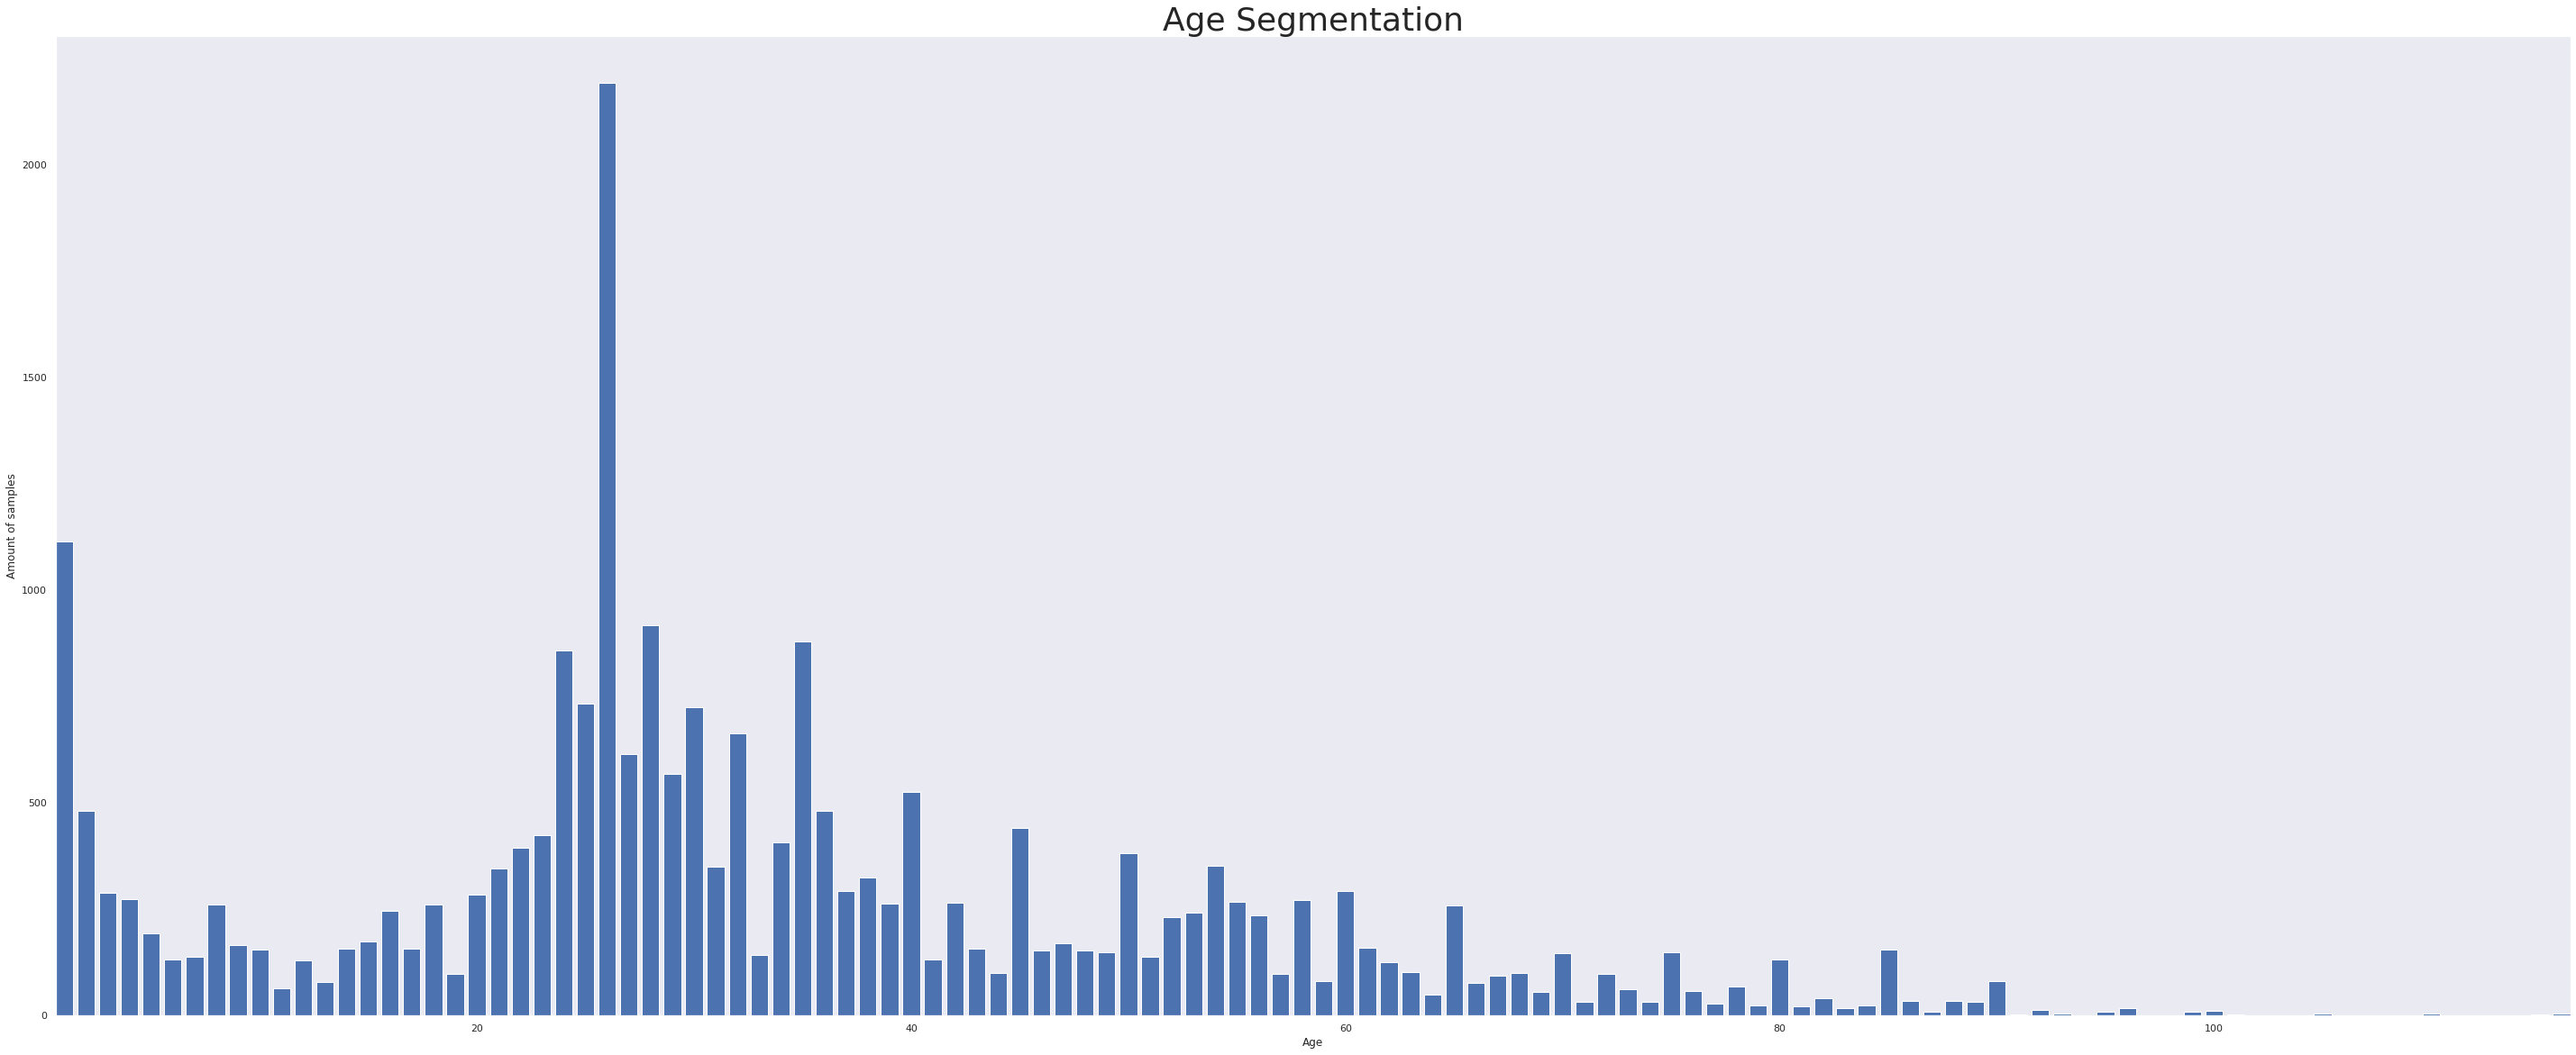

In [ ]:
x_ages = list(set(ages))
y_ages_count = [ages.count(i) for i in x_ages]
plt.figure(figsize=(50, 20))
plt.bar(x_ages, y_ages_count)
plt.title("Age Segmentation", fontsize=36) 
plt.xlabel("Age") 
plt.ylabel("Amount of samples") 
plt.margins(x=0)
plt.grid()

print("Max age:",max(ages))
print("Min age:",min(ages))

We can see the age segmentation of our dataset in the graph. Our concern is that we don't have enough samples of older ages and teenage periods. We assume it will affect our accuracy of an age prediction model.

## Looking at the distribution of genders in our dataset samples

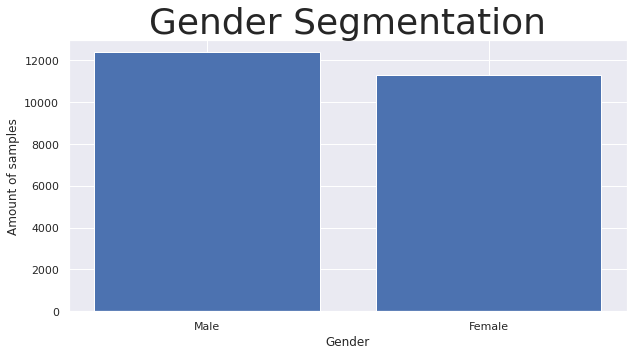

In [ ]:
x_genders = list(set(genders))
y_genders_count = [genders.count(i) for i in x_genders]

plt.figure(figsize=(10, 5))
plt.bar(x_genders, y_genders_count)
plt.title("Gender Segmentation", fontsize=36) 
plt.xlabel("Gender") 
plt.ylabel("Amount of samples") 
plt.xticks(x_genders, ['Male', 'Female'])

plt.show()

We can see that we have a quite equal amount of male/female samples, which is good for our gender classification mission.

## Looking at the distribution of races in our dataset samples

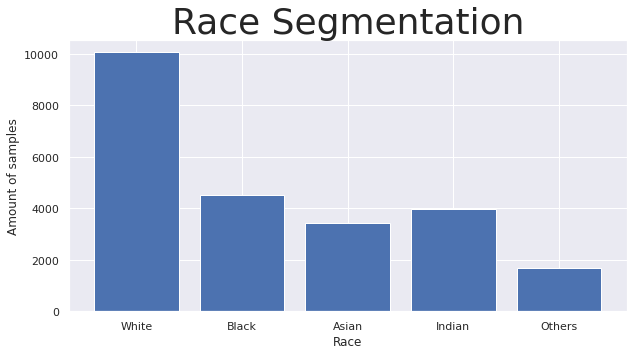

In [ ]:
x_races = list(set(races))
y_races_count = [races.count(i) for i in x_races]

plt.figure(figsize=(10, 5))
plt.bar(x_races, y_races_count)
plt.title("Race Segmentation", fontsize=36) 
plt.xlabel("Race") 
plt.ylabel("Amount of samples") 
plt.xticks(x_races, ['White', 'Black', 'Asian', 'Indian', 'Others'])

plt.show()

We do not know if we will use the race label in our model, but we can see that the dataset contains mostly white people photos, other than that the other races are pretty equally distributed. This still might be an issue - our model might classify white people in a better accuracy than other races.

# Classifiying Age (UTK)

We are going to divide the ages into the next age groups:

**0 - 4**

**5 - 12**

**13 - 19** 

**19 - 27** 

**28 - 39** 

**40 - 59** 

**60 - 74** 

**75 and older** 


We are going to use the fastai library in order to try and predict age by a face-photo. fastai gives us an easy api to use neural networks (among the rest), and declares pretty good performance and accuracy as well.

Some code to help us divide the photos to age groups, and extract this age group label from the photo name:

In [ ]:
def age_to_age_group(age):
  if (age < 5):
    return 0
  elif (age < 13):
    return 1
  elif (age < 19):
    return 2
  elif (age < 27):
    return 3
  elif (age < 40):
    return 4
  elif (age < 60):
    return 5
  elif (age < 75):
    return 6
  else:
    return 7

AGE_GROUP_IDX_TO_LABEL = {
    0: "0-4",
    1: "5-12",
    2: "13-18",
    3: "19-26",
    4: "27-39",
    5: "40-59",
    6: "60-74",
    7: ">74"
}

GENDER_LABEL_TO_TEXT = {
    0: "Male",
    1: "Female"
}

def extract_age(filename):
  return int(filename.stem.split('_')[AGE_INDEX])

def extract_age_group(filename):
  return age_to_age_group(extract_age(filename))

def extract_age_label(filename):
  return AGE_GROUP_IDX_TO_LABEL[extract_age_group(filename)]

def extract_gender(filename):
  return int(filename.stem.split('_')[GENDER_INDEX])

def extract_gender_label(filename):
  return GENDER_LABEL_TO_TEXT[extract_gender(filename)]

We will now load the data into an ImageList fastai object, and use the fastai transform method to enrich our photos with more angles of each photo.
We are splitting the dataset here by a factor of 0.2: 20% of the photos will be used for the validation set, the other 80% will be our training set. 

On the first phase, we will use image size of 128 to train our model. Later on we may want to retrain our model with the same data but bigger size.

## Classify Age Group only

In [ ]:
path = fav.Path('/tmp/UTKFace_dataset_clean/UTKFace')
tfms = fav.get_transforms()
data_128 = (fav.ImageList.from_folder(path)
        .split_by_rand_pct(0.2, seed = 42)
        .label_from_func(extract_age_label)
        .transform(tfms, size = 128)
        .databunch(bs=256)
        .normalize(fastai.vision.imagenet_stats))

Lets look at some of the photos and their lables:

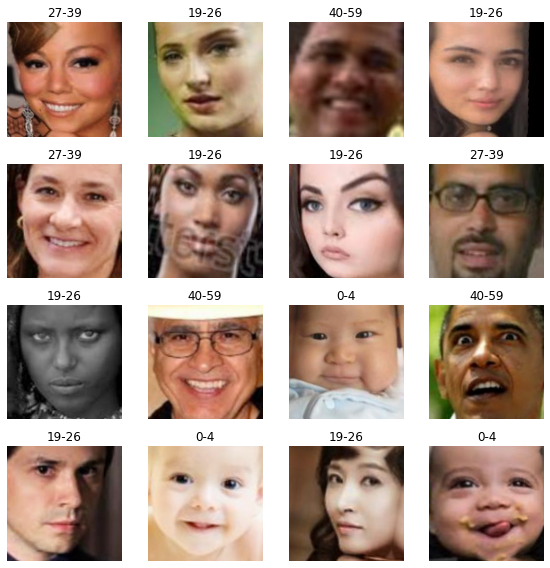

In [ ]:
data_128.show_batch(rows = 4, figsize = (8,8))

Now we are ready to feed our dataset into a learner object. We will use a CNN as it seems as a classic easy model for image-classification problems. We will start with a pre-defined resnet34 model which fastai allows to use easily.

First will try to find the best learning rate to train our model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 1.45E-02


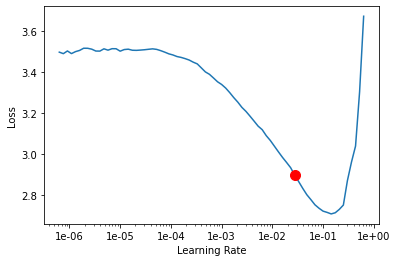

In [ ]:
age_learner = fav.cnn_learner(data_128, fav.models.resnet34, metrics = [fav.error_rate , fav.accuracy])
age_learner.path = fav.Path('/content/gdrive/My Drive/fastai-models/')
age_learner.lr_find()
age_learner.recorder.plot(suggestion = True)

According the loss plot, we should pick 5e-2 as our learning rate, because it seems to be the steepest but not the bottom yet.


Now we use the fit_one_cycle method fastai cnn_learner provides us, to start and train the model. We will start with 5 epochs (rounds of the model going over all of our data, pass it through the network, recalculate weights...)

In [ ]:
lr = 1e-1
age_learner.fit_one_cycle(5, slice(lr/2))

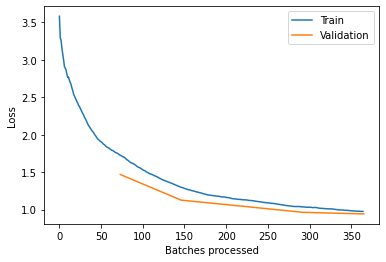

In [ ]:
age_learner.recorder.plot_losses()

Unfortunately, we are getting pretty bad results.
Starting with 47% accuracy which is disappointing. But we do see a very big improvement over the epochs, 12% increase of accuracy - ending with 59% which is not so bad but we might be able to improve it later on.
(We have 8 classes, so accuracy of 59% is much better then random guess [12.5%])

We will save our trained learner just in case we want to go back and use it from the same spot later.

In [ ]:
age_learner.save('age-1-128')

The resnet34 model we used, is a predefined model which was trained on a big dataset of photos of many kinds. The fitting cycles we performed, only trained layers that fastai adds above the model. Now we will try to train only few last layer to get better accuracy

In [ ]:
age_learner.freeze_to(-2)
age_learner.fit_one_cycle(2)

We observed that training only the last 2 layers improved model accuracy, so now we will train the last 3 layers and check if it's get improved

In [ ]:
age_learner.freeze_to(-3)
age_learner.fit_one_cycle(2)

Now we wil try to unfreeze the entire model and train it by 5 epoch

In [ ]:
age_learner.unfreeze()
age_learner.fit_one_cycle(5)

In [ ]:
age_learner.save('age-128-65-precent')

After trainning last few layer we increased model accuracy by 5 precent! 


We will now create a new data object from the same data, BUT use 256 pixel images. FastAI Course tells us of this method to improve a model accuracy - we didn't see it proved in an academic paper, but turns out using different image sizes might help a bit.

In [ ]:
data_256 = (fav.ImageList.from_folder(path)
        .split_by_rand_pct(0.2, seed = 42)
        .label_from_func(extract_file_label)
        .transform(tfms, size = 256)
        .databunch(bs=32)
        .normalize(fastai.vision.imagenet_stats)) 
age_learner.data = data_256
age_learner.unfreeze()
age_learner.fit_one_cycle(5, slice(3e-4))

After training our model with the "new" dataset, let's try to follow above steps and train only lastest layers.

In [ ]:
age_learner.freeze_to(-2)
age_learner.fit_one_cycle(2)

In [ ]:
age_learner.freeze_to(-3)
age_learner.fit_one_cycle(2)

Retrain the model with same data but bigger image size didn't improve the accuracy so much, so we will not use this technique in our next model.

Lets look at some of our model mistakes:

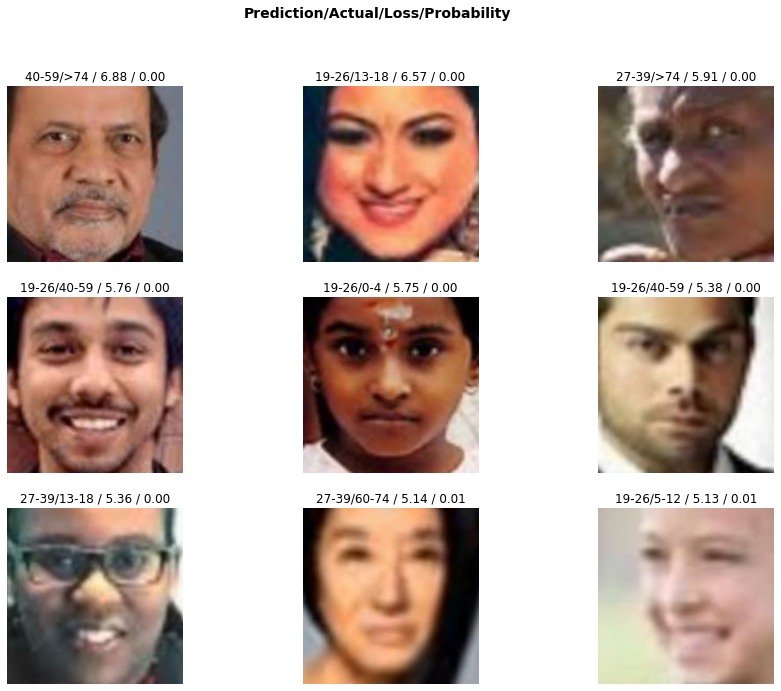

In [ ]:
interp = fastai.vision.ClassificationInterpretation.from_learner(age_learner)
interp.plot_top_losses(9, figsize=(15,11))

We can see that some of the worst mistakes (our model was very confident of its prediction, while it was wrong) were on blurry photos. To be honest, as humans, we would not choose better than our model :)

[('19-26', '27-39', 357),
 ('27-39', '19-26', 334),
 ('40-59', '27-39', 225),
 ('27-39', '40-59', 145),
 ('60-74', '40-59', 114),
 ('40-59', '60-74', 74),
 ('13-18', '19-26', 64),
 ('60-74', '>74', 42),
 ('>74', '60-74', 40),
 ('0-4', '5-12', 36),
 ('13-18', '5-12', 36),
 ('5-12', '13-18', 36),
 ('19-26', '13-18', 21),
 ('40-59', '19-26', 21),
 ('5-12', '0-4', 16),
 ('19-26', '40-59', 10),
 ('13-18', '27-39', 9),
 ('5-12', '19-26', 7),
 ('27-39', '13-18', 4),
 ('>74', '40-59', 4),
 ('40-59', '>74', 3),
 ('5-12', '27-39', 3),
 ('60-74', '27-39', 3),
 ('0-4', '19-26', 2),
 ('19-26', '5-12', 1),
 ('27-39', '5-12', 1),
 ('40-59', '13-18', 1),
 ('40-59', '5-12', 1),
 ('>74', '27-39', 1)]

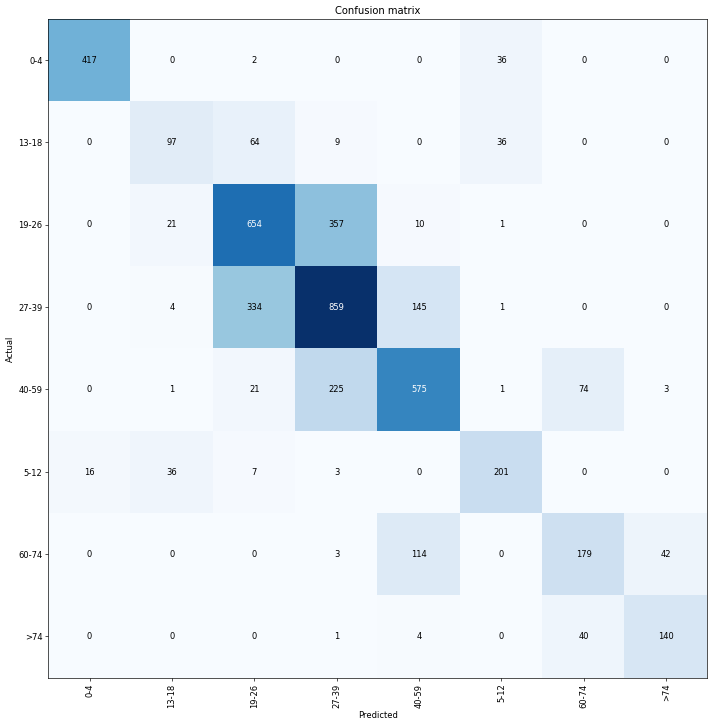

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused()

We can see that the massive amount of mistakes happen between close age groups (adults-middle aged, adults-young, etc) so this isn't very surprising.

Concluding this section, we acheived almost 66% accuracy of classifying age group using pre-trained resnet34 model and applying some more training techniques. 

Now we will check if classifying age + gender provides better accuracy.

## Classify Age & Gender label

We will try to apply the same training steps but using age group + gender label to see if the classifying based of age + gender will provide better accuracy. We want to check if a model behaves better, when it is trained with examples classified with both gender and age.

In [ ]:
def extract_file_label(filename):
  return extract_age_label(filename) + "_" + extract_gender_label(filename)

tfms = fav.get_transforms()
data_128 = (fav.ImageList.from_folder(path)
        .split_by_rand_pct(0.2, seed = 42)
        .label_from_func(extract_file_label)
        .transform(tfms, size = 128)
        .databunch(bs=256)
        .normalize(fastai.vision.imagenet_stats))
age_gender_learner = fav.cnn_learner(data_128, fav.models.resnet34, metrics = [fav.error_rate , fav.accuracy])

lr = 1e-2
age_gender_learner.fit_one_cycle(5, slice(lr))

In [ ]:
age_gender_learner.freeze_to(-2)
age_gender_learner.fit_one_cycle(4)

In [ ]:
age_gender_learner.freeze_to(-3)
age_gender_learner.fit_one_cycle(2, max_lr=slice(1e-06))

Now we wil try to unfreeze the entire model and train it by 5 epochs:

In [ ]:
age_gender_learner.unfreeze()
age_gender_learner.fit_one_cycle(5)

We managed to acheive almost 60% accuracy, of classifying age + gender simultaneously.
We will not try to feed our model with 256 pixel data, because we observed no real improvment by doing it. As you see, we have already achieved 65% accuracy by classifying age group only. 

Let's take a look on most confussion photos:

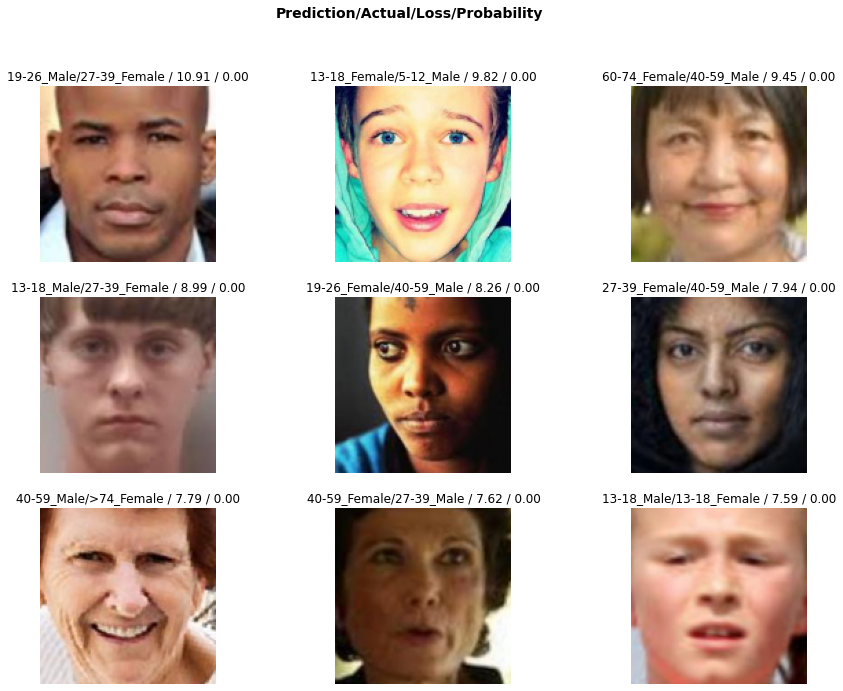

In [ ]:
interp = fastai.vision.ClassificationInterpretation.from_learner(age_gender_learner)
interp.plot_top_losses(9, figsize=(15,11))

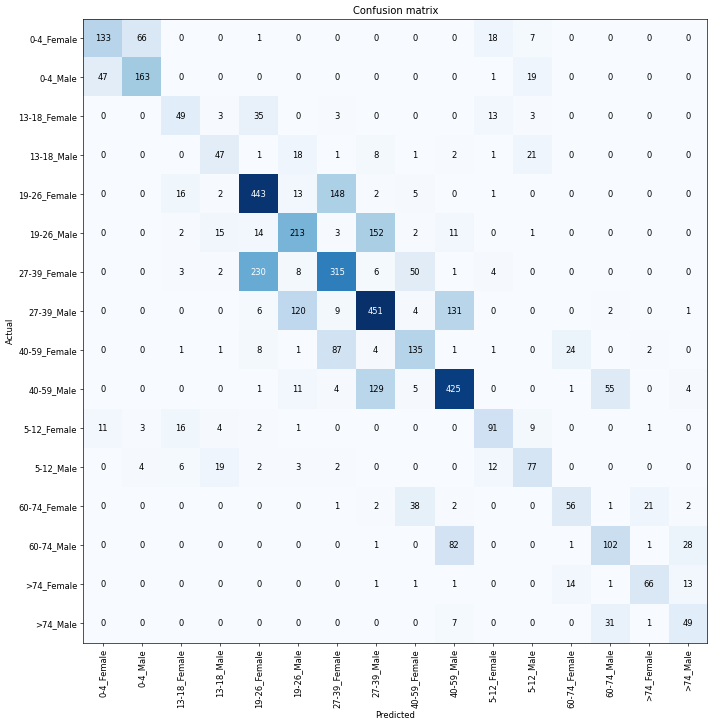

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)s

From confussion matrix we can see that the most confussions are between Sequential age group, not gender confussion (predict correct gemder, but wrong age)

To conclude last 2 sub sections:

Our goal was to classify a human image to an age group. We tried to classify by age only and we acheived 65% accuracy. We tried to classify by age and gender, but we acheived 60% accuracy only. The number of classes double on age+gender label so the related accuracy compare to 6.75 (16 labels) is higher than 12.5. But our goal was to classify **age** then the first try was better from this prespective.


## Exact Age Classification Measuring Error and not Accuracy

Up to now, we approached the detection of age from image as a classification problem. We tried various ways to find the age, mainly trying to divide the ages into age groups. As we created a lower amount of labels - we measured exact accuracy and used that as the number representing our results (which were pretty poor).

Lets try another approach. Before, we hard-coded our age groups, making us "lose points" if, for instance, our model thinks the age is 39, when the actual age is 40, but the age groups were divded as 30-39, 40-49.

In the next approach, we are going to let our model predict exact age - and measure our error as the distance from the actual age. That way, the problem mentioned above isn't concerning - if our model predicts a 40 year old as a 39 years old, it will count as only 1-year error - which is pretty good.

In [ ]:
path = fav.Path('/tmp/UTKFace_dataset_clean/UTKFace')
tfms = fav.get_transforms()
data_128 = (fav.ImageList.from_folder(path)
        .split_by_rand_pct(0.2, seed = 42)
        .label_from_func(func=extract_age, label_cls=fav.FloatList)
        .transform(tfms, size = 128)
        .databunch()
        .normalize(fastai.vision.imagenet_stats))

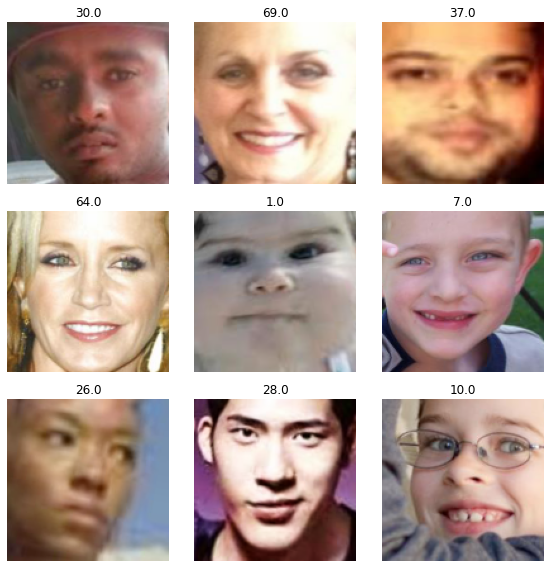

In [ ]:
data_128.show_batch(rows = 3, figsize = (8,8))

We will use root mean squared error as our error metric. This is a standard metric to measure the "average" distance from the actual labels the most precise way. This metric takes each error, squares it, sums all of them and divides by the amount of examples, and then performs a square root.
Lets start:

In [ ]:
exact_age_learner = fav.cnn_learner(data_128, fav.models.resnet34, metrics = [fav.root_mean_squared_error])
exact_age_learner.fit_one_cycle(5,max_lr=5e-02)

In [ ]:
exact_age_learner.unfreeze()
exact_age_learner.fit_one_cycle(3,slice(1e-06))

In [ ]:
exact_age_learner.freeze_to(-2)
exact_age_learner.fit_one_cycle(3)

In [ ]:
exact_age_learner.freeze_to(-3)
exact_age_learner.fit_one_cycle(3)

In [ ]:
exact_age_learner.fit_one_cycle(5)

In [ ]:
exact_age_learner.unfreeze()
exact_age_learner.fit_one_cycle(5)

We have got to 6.88 years error - which is pretty good, in our opinion! Even a human can guess a 40 years old to a 47, etc..
We will save our model:

In [ ]:
exact_age_learner.export("exact-age-utk-6.88-error.pth")

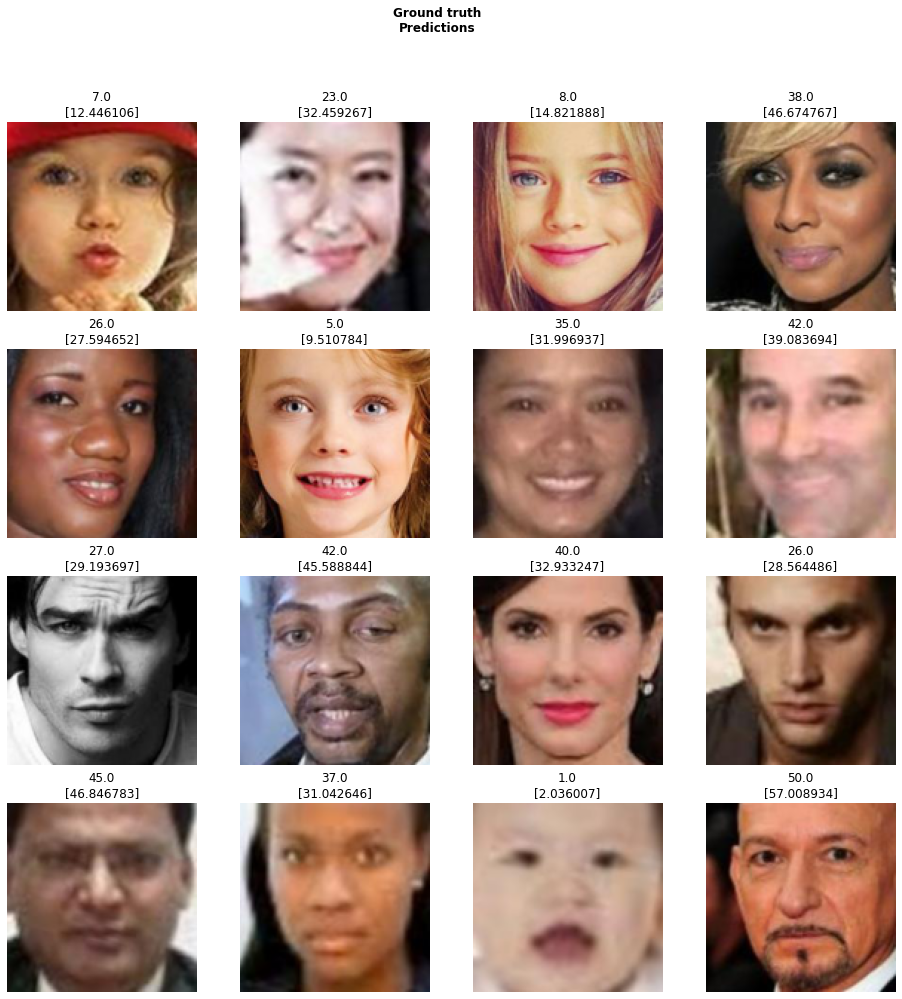

In [ ]:
exact_age_learner.show_results(rows=4)

Results are pretty satisfying. Even though we obviously have mistakes, and some of them - a human wouldn't do - it still seems as even where it confuses, there is a solid reason for that (blurry photo or just a picture which can't tell us an exact age of a person very easily).

Now we will look at the distribution of our errors, using fast ai "get_preds" method which gives us all of the model predictions and targets.

In [ ]:
predictions, targets = exact_age_learner.get_preds()

In [ ]:
x = []
y = []

for i, v in enumerate(predictions):
  x.append(targets[i].item())
  y.append(v.item())

In [ ]:
age_to_predicts = {}

for age in range (120):
  age_to_predicts[age + 1] = []
  
for i, v in enumerate(x):
  age_to_predicts[v].append(y[i])

In [ ]:
age_predicts_avg = {}

for age in range (120):
  if len(age_to_predicts[age + 1]) > 0:
    age_predicts_avg[age + 1] = sum(age_to_predicts[age + 1]) / len(age_to_predicts[age + 1])

In [ ]:
x_ages = []
y_avg_loss = []

for k in age_predicts_avg:
  x_ages.append(k)
  y_avg_loss.append(abs(age_predicts_avg[k] - k))

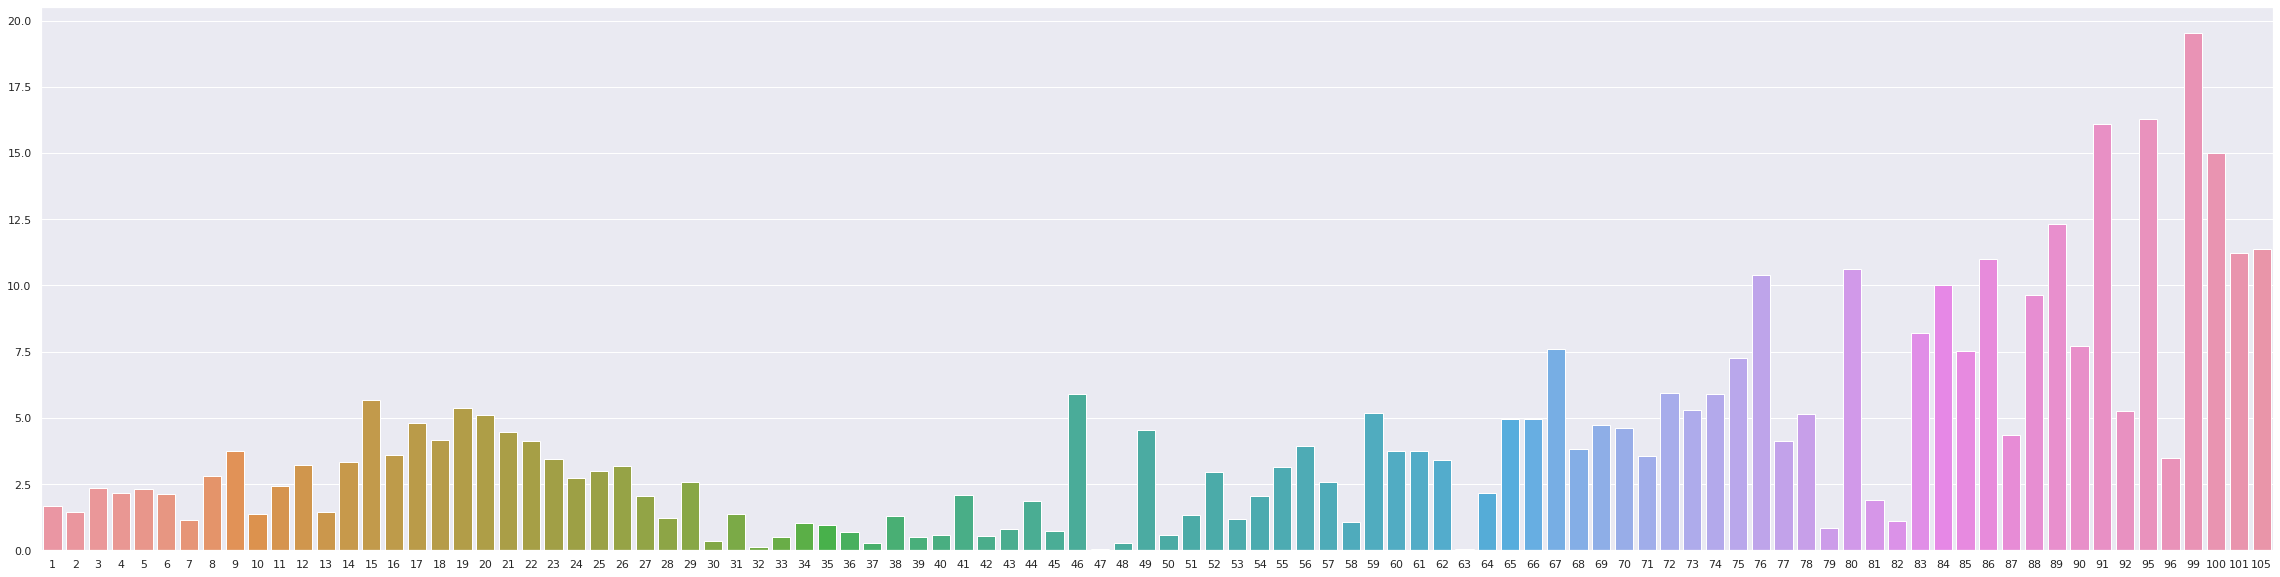

In [ ]:
sns.set(rc={'figure.figsize':(40,10)})
sns.barplot(x_ages, y_avg_loss)

The graph above shows us the average error of our model for each age. We can clearly see that in the middle ages we have a pretty accurate model - around ages 20-70 We have a max error rate of 5 years.
Younger ages - pretty close to that, and older ages have worse errors. This all makes sense as our dataset contained much more examples of middle ages, and also - even for a human, it is easier to make a mistake guessing an old man or woman exact age.


Seems like the exact-age approach, measuring distance as error, was the best and it gave us a pretty nice model for age prediction.

# Age Classification using FairFace dataset

Working with UTK dataset, validation set was built by a random function.
This caused us to explore another dataset which is much bigger and is already devided into train/val sets.

We chose to try [FairFace](https://github.com/joojs/fairface) dataset for age and gender classification because it is more balanced and it is already splitted into training and validation sets.

Becuase the dataset is splitted, we need to merge the validation and test set to explore the entire data. We will keep the source of the data (valid/train) by adding a new boolean column called valid.

In [ ]:
shutil.unpack_archive('/content/gdrive/My Drive/Colab_Notebooks/fairface-img-margin025-trainval.zip', '/tmp/fairface')
shutil.copy('/content/gdrive/My Drive/Colab_Notebooks/fairface_label_val.csv', '/tmp/fairface')
shutil.copy('/content/gdrive/My Drive/Colab_Notebooks/fairface_label_train.csv', '/tmp/fairface')

'/tmp/fairface/fairface_label_train.csv'

In [ ]:
# Parse data into panda dataframe
os.chdir( '/tmp/fairface')
trainSet = pd.read_csv('fairface_label_train.csv')
validationSet = pd.read_csv('fairface_label_val.csv')

trainSet["valid"] = False
validationSet["valid"] = True

#concat 2 set into a full set
fullSet =  pd.concat([trainSet, validationSet])
print(fullSet)

images = fullSet['file']
ages = fullSet['age'].tolist()
genders = fullSet['gender'].tolist()
races = fullSet['race'].tolist()
 
ageSet = set()
for item in ages:
  ageSet.add(item)

                file    age  gender             race  service_test  valid
0        train/1.jpg  50-59    Male       East Asian          True  False
1        train/2.jpg  30-39  Female           Indian         False  False
2        train/3.jpg    3-9  Female            Black         False  False
3        train/4.jpg  20-29  Female           Indian          True  False
4        train/5.jpg  20-29  Female           Indian          True  False
...              ...    ...     ...              ...           ...    ...
10949  val/10950.jpg  30-39    Male            White          True   True
10950  val/10951.jpg  50-59    Male            White         False   True
10951  val/10952.jpg  60-69    Male  Latino_Hispanic         False   True
10952  val/10953.jpg  20-29  Female       East Asian         False   True
10953  val/10954.jpg  40-49    Male  Latino_Hispanic          True   True

[97698 rows x 6 columns]


##Exploring FairFace dataset

The data is labeled and devided into validation and train sets includes following labels:

Age - a string that represent range ('0-2', '3-9', '10-19', '20-29', '30-39' , '40-49', '50-59', '60-69', 'more than 70') .

Gender - either Male or Female string.

Race - a string: 'White', 'Middle Eastern', 'East Asian', 'Latino_Hispanic', 'Indian', 'Black', 'Southeast Asian'.

### Looking at the distribution of ages in our dataset samples

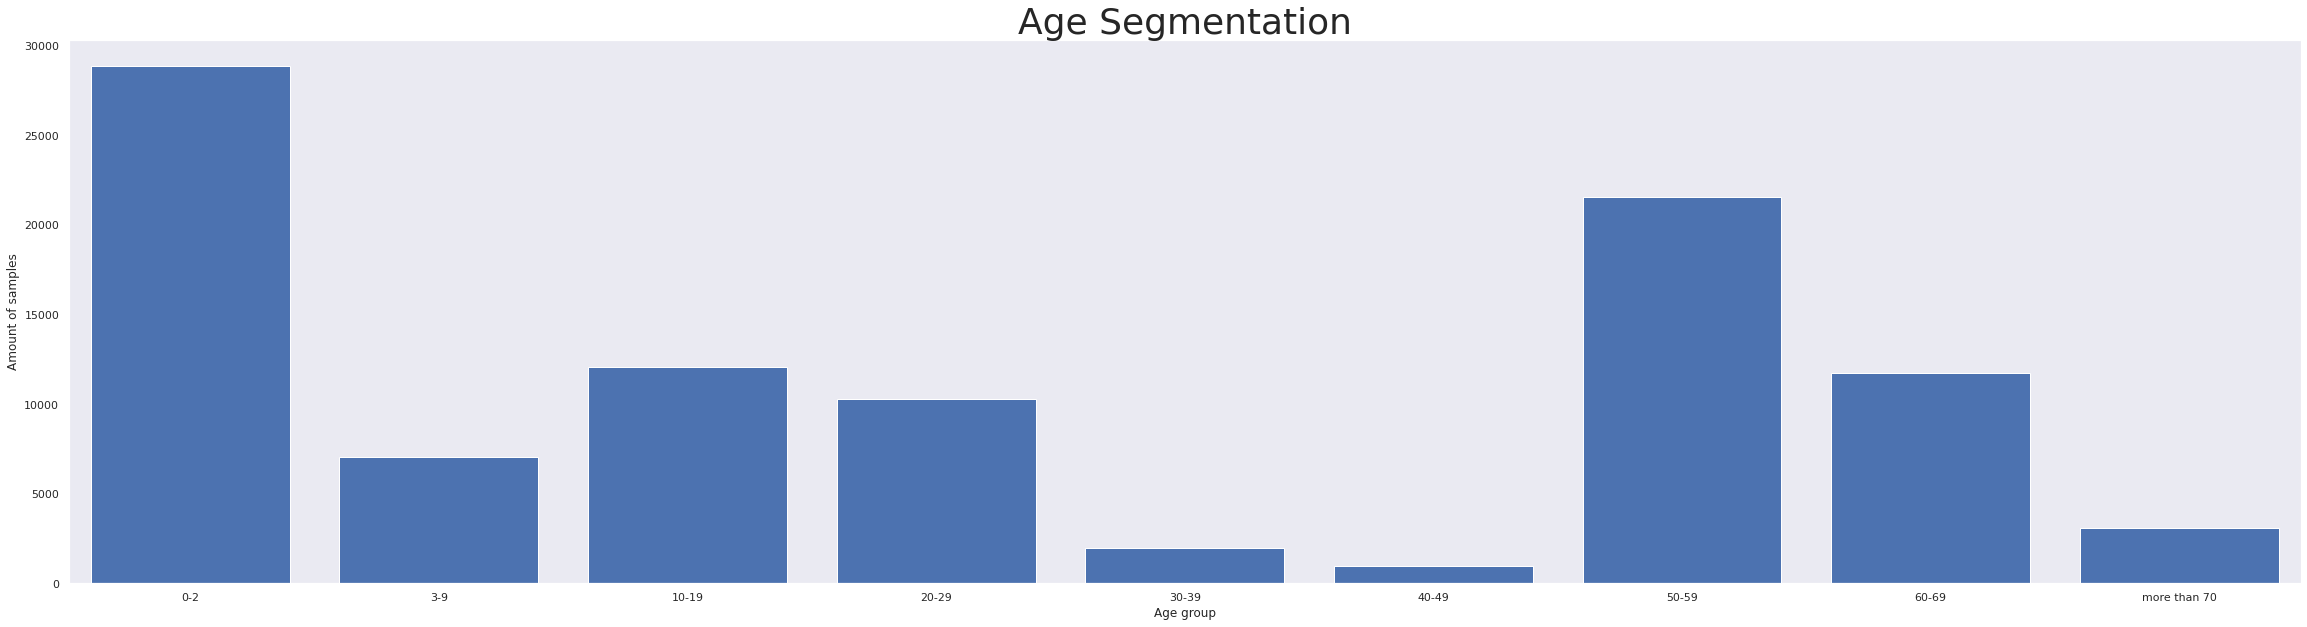

In [ ]:
#Age segmentation
x_ages = list(set(ages))
y_ages_count = [ages.count(i) for i in x_ages]

plt.figure(figsize=(40, 10))
plt.bar(x_ages, y_ages_count)

#order x_axis
age_group_order = ['0-2', '3-9', '10-19', '20-29', '30-39' , '40-49', '50-59', '60-69', 'more than 70']
plt.xticks(range(len(x_ages)), age_group_order)

plt.title("Age Segmentation", fontsize=36) 
plt.xlabel("Age group") 
plt.ylabel("Amount of samples") 
plt.margins(x=0.01)
plt.grid()

Here, as before, We can see the age segmentation of our dataset in the graph, and our concern is that we don't have enough samples of edge range. We assume it will affect the accuracy of the age prediction model.

### Looking at the distribution of genders in our dataset samples

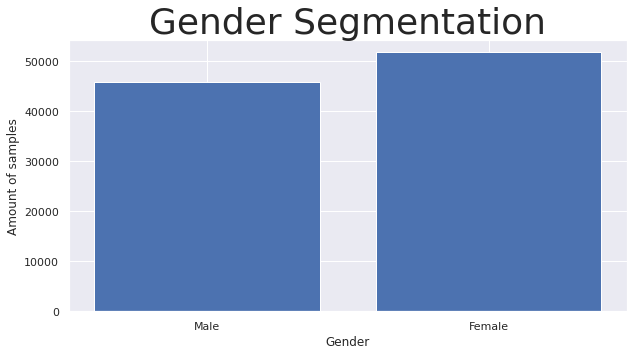

In [ ]:
x_genders = list(set(genders))
y_genders_count = [genders.count(i) for i in x_genders]

plt.figure(figsize=(10, 5))
plt.bar(x_genders, y_genders_count)
plt.title("Gender Segmentation", fontsize=36) 
plt.xlabel("Gender") 
plt.ylabel("Amount of samples") 
plt.xticks(x_genders, ['Male', 'Female'])

plt.show()

### Looking at the distribution of races in our dataset samples

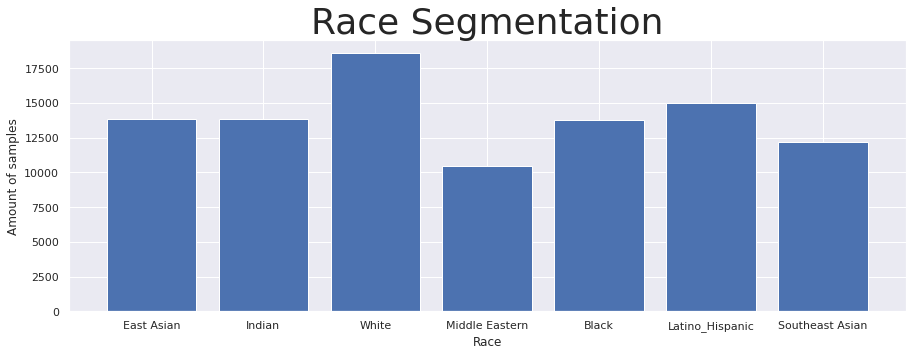

In [ ]:
x_races = list(set(races))
y_races_count = [races.count(i) for i in x_races]

plt.figure(figsize=(15, 5))
plt.bar(x_races, y_races_count)
plt.title("Race Segmentation", fontsize=36) 
plt.xlabel("Race") 
plt.ylabel("Amount of samples") 

plt.show()

We can see that the data is quite balanced, which means that our model unlikely to suffer from "racism".

## Classifiying Age Group (FairFace)

We will now load the data into an ImageList fastai object, and use the fastai transform method to enrich our photos with more angles of each photo.

On the first phase, we will use image size of 64 to train our model. Later on we may want to retrain our model with the same data but bigger size.

In [ ]:
path = fav.Path('/tmp/fairface')
tfms = fav.get_transforms()
age_data_128 = (fav.ImageList.from_df(fullSet,path)
        .split_from_df(col='valid')
        .label_from_df()
        .transform(tfms, size = 128)
        .databunch(bs=256)
        .normalize(fastai.vision.imagenet_stats))

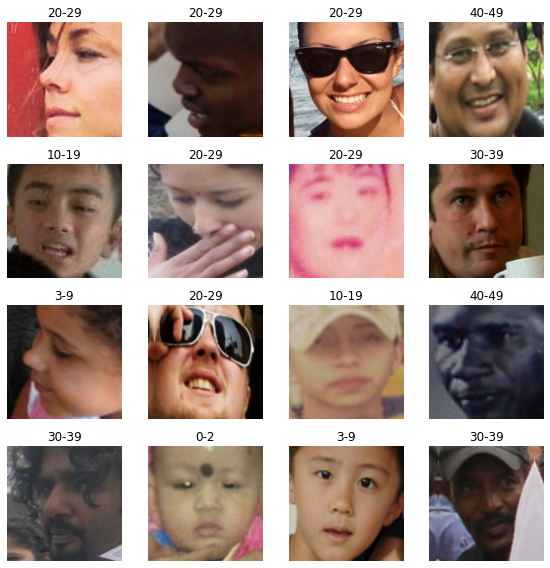

In [ ]:
age_data_128.show_batch(rows = 4, figsize = (8,8))

Create leaner that use pre-trains resent34 model and find the optimal learning rate for our first train.

In [ ]:
age_learner = fav.cnn_learner(age_data_128, fav.models.resnet50, metrics = [fav.error_rate, fav.accuracy])


The difference between **fit** and **fit_one_cycle** methods is fit_one_cycle using SGDR (Stochastic Gradient Descent with Restart) using 1cycle policy. In SGDR the learning rate is reset at the start of each epoch to the original chosen value which decreases over the epoch as in Cosine Annealing. The main benefit of this, is that since the learning rate is reset at start of each epoch, the learner is capable of jumping out of a local minima or a saddle point it may be stuck in.


We will start with 5 epochs (rounds of the model going over all of our data, pass it through the network, recalculate weights...)

In [ ]:
age_learner.fit_one_cycle(5, 4e-02)

In [ ]:
age_learner.unfreeze()

In [ ]:
age_learner.fit_one_cycle(3, max_lr=2.3e-06)

We acheived a minor improvment from last training, but we will keep trying.

Next we will try to train only the last 2/3 group of layers of the model in order increase the accuracy

In [ ]:
age_learner.freeze_to(-2)
age_learner.fit_one_cycle(5)

In [ ]:
age_learner.freeze_to(-3)
age_learner.fit_one_cycle(5)

By training the only last few layers of the model we succeeded to increase accuracy by 5% while keeping our model not overfitted (valid_loss is not increased during the trainning)

Let's try to train the model with the same data but using images twice big

In [ ]:
age_data_256 = (fav.ImageList.from_df(fullSet,path)
        .split_from_df(col='valid')
        .label_from_df()
        .transform(tfms, size = 256)
        .databunch(bs=64)
        .normalize(fastai.vision.imagenet_stats))

In [ ]:
age_learner_256 = fav.cnn_learner(age_data_256, fav.models.resnet50, metrics = [fav.error_rate, fav.accuracy])
age_learner_256.load("age-fair-128-58precent")
age_learner_256.fit_one_cycle(3,max_lr=3.3e-03)

In [ ]:
age_learner_256.save("age-fair-256-55precent")
age_learner_256.export("age-fair-256-55precent")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.79E-07


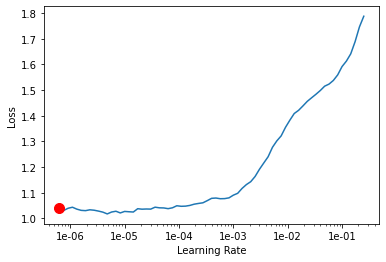

In [ ]:
age_learner_256.unfreeze()
age_learner_256.lr_find()
age_learner_256.recorder.plot(suggestion = True)

In [ ]:
age_learner_256.fit_one_cycle(3, max_lr=slice(6.3e-06))

In [ ]:
age_learner_256.freeze_to(-2)
age_learner_256.fit_one_cycle(3)

In [ ]:
age_learner_256.fit_one_cycle(3)

In [ ]:
age_learner_256.freeze_to(-1)
age_learner_256.fit_one_cycle(3)

The result isn't satisfying and isn't better than using the UTKFace dataset.

# Classifiying Gender (UTK)

The UTKFace dataset labels the photos by gender:

**0** - Male

**1** - Female

We will use fastai to try and predict the gender of a person by a face-photo.
The process is going to be very similar to the age-classifying process.

In [ ]:
path = fav.Path('/tmp/UTKFace_dataset_clean/UTKFace/')
tfms = fav.get_transforms()

data = (fav.ImageList.from_folder(path)
        .split_by_rand_pct(0.2, seed = 42)
        .label_from_func(extract_gender_label)
        .transform(tfms, size = 128)
        .databunch(bs=256)
        .normalize(fastai.vision.imagenet_stats))

Lets look at some of the photos and their lables:

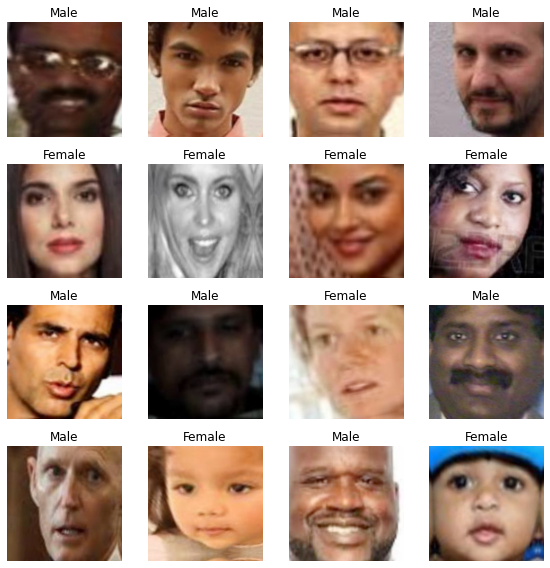

In [ ]:
data.show_batch(rows = 4, figsize=(8,8))

And now we will try to train our model:

In [ ]:
gender_learner = fav.cnn_learner(data, fav.models.resnet34, metrics = [fav.error_rate, fav.accuracy])
gender_learner.fit_one_cycle(5, max_lr=1.5e-02)

We acheived 92.2% accuracy of predicting our validation set photos gender, after only 5 epochs! Pretty impressing and surprising for the first try. We will now save our acheivment.

We will now see if we can make it even better:

In [ ]:
gender_learner.unfreeze()
gender_learner.fit_one_cycle(3, max_lr=1.5e-06)

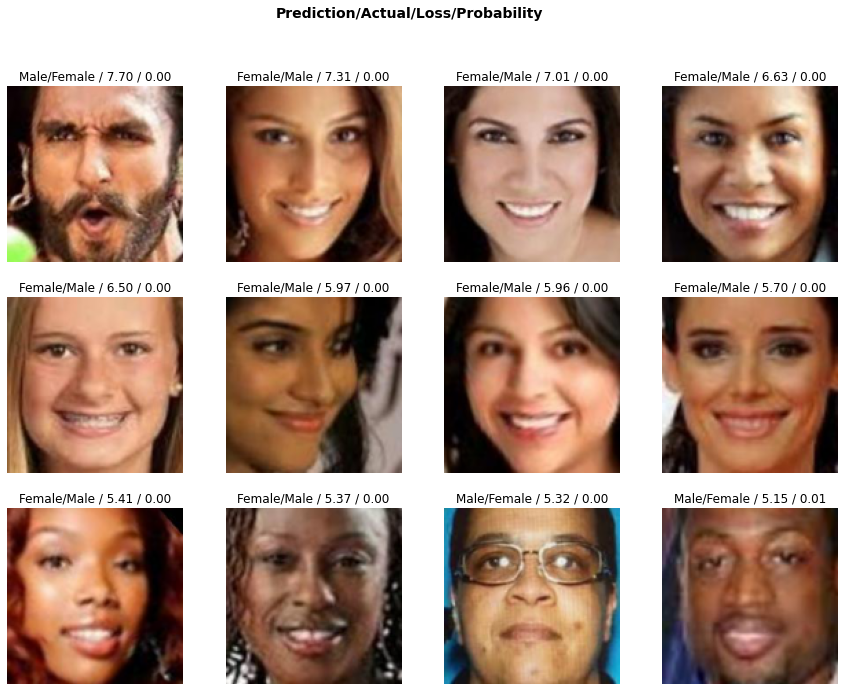

In [ ]:
gender_interp = fav.ClassificationInterpretation.from_learner(gender_learner)
gender_interp.plot_top_losses(12, figsize=(15,11))

Looking at our model top mistakes, we can see some obvious mistakes in the dataset itself! Some photos here, which are clear males, are tagged as females, and vice versa as well. We noticed the same thing when we first trained our age-classifier. 

We will try to train only last layer, we may improve the accuracy although obviously we have some wrong labeled images

In [ ]:
gender_learner.freeze_to(-2)
gender_learner.fit_one_cycle(3)

In [ ]:
gender_learner.path = fav.Path('/content/gdrive/My Drive/data_science_final_project/')
gender_learner.export("gender-93.7")

We are happy with the accuracy we acheived in gender classification, so we stop here.

# Emotions Classification

Up to now, we dealt with age and gender. Now we would like to give our stretch goal a shot and try identify people's emotions from their faces. We will use the FER2013 Dataset presented in the beginning.

In [ ]:
shutil.unpack_archive('/content/gdrive/My Drive/Datasets/facial-expression-recognitionferchallenge.zip', '/tmp/emotions')
fer2013 = pd.read_csv("/tmp/emotions/fer2013/fer2013/fer2013.csv", delimiter=',')
fer2013.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [ ]:
fer2013["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

As we can see, the dataset is divided into training and test sets. We will soon explain the public-private test difference.

In [ ]:
emotion_label_to_text = {
    0:'anger',
    1:'disgust',
    2:'fear',
    3:'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'}
emotion_counts = fer2013['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'amount']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_label_to_text)
emotion_counts

emotion  amount
0      anger    4953
1    disgust     547
2       fear    5121
3  happiness    8989
4    sadness    6077
5   surprise    4002
6    neutral    6198

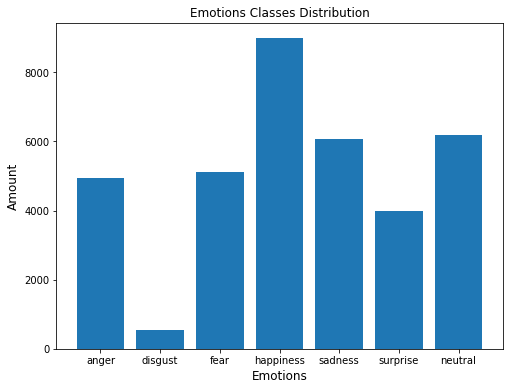

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(emotion_counts.emotion, emotion_counts.amount)
plt.title('Emotions Classes Distribution')
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.show()

As we can see, happiness has a significant amount of examples in our dataset. Other emotions are presented in the dataset as well, except for disgust which we barely have examples of, and surprise is also less presented than others. We will note that in mind and might try and dispose some of the labels later on.

The fer2013 dataset contains three usages - each image is used for either "Training", "PublicTest", or "PrivateTest". Two test usages exist because this dataset was used in a kaggle competition, in order to avoid overfitting. We are going to combine both tests usages into our validation set.
Lets look at the distribution of emotion-classes between our train and validation sets and make sure they are similar:

In [ ]:
train_df = fer2013[fer2013['Usage'] == 'Training']
valid_df = fer2013[fer2013['Usage'] != 'Training']

In [ ]:
valid_df['emotion'].value_counts(normalize=True) * 100

3    24.714405
4    17.372527
6    17.177487
2    14.265812
0    13.346336
5    11.577041
1     1.546392
Name: emotion, dtype: float64

In [ ]:
train_df['emotion'].value_counts(normalize=True) * 100

3    25.131492
6    17.294228
4    16.823992
2    14.270786
0    13.915497
5    11.045317
1     1.518688
Name: emotion, dtype: float64

As we can see, the percentages of each emotion class in our training set is very similar to our validation set. 

The fer2013 dataset provides the pixels of the image, not the image itself. fastai provides us a convinient way to work with image files, even more than pixels, which is pretty ironic because images are built of pixels and the input of the cnn will be the pixels values..
Therefore, we had to go over the data and prepare it for fastai. We converted the pixels in the csv to images, and distributed them to train and validation folders, which are splitted to the emotions labels. We used both tests sets for validation.

This is the code we wrote to perform the above (we ran it locally):

In [ ]:
df = pd.read_csv("./resources/fer2013.csv")

label_to_emotion = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

folder_map = {
    'PrivateTest': 'valid',
    'PublicTest': 'valid',
    'Training': 'train'
}

count = 0
flag = True

for index, row in df.iterrows():
    emotion_label = row['emotion']
    usage = row['Usage']
    if usage != 'Training' and flag:
        count = 0
        flag = False
    image_pixels = row['pixels']
    image_string = image_pixels.split(' ')
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48, 48)
    image_file_name = "./images/labeled/{0}/{1}/{2}.jpg".format(folder_map[usage], label_to_emotion[emotion_label], count)
    Image.fromarray(image_data).save(image_file_name)
    count = count + 1

Lets load the images and feed them to a learner:

In [ ]:
shutil.unpack_archive('/content/gdrive/My Drive/Datasets/fer_images.zip', '/tmp/fer_emotions_images')

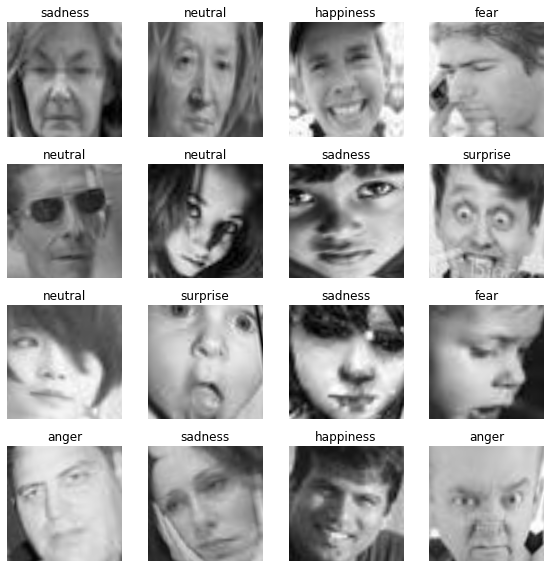

In [ ]:
emotions_path = fav.Path('/tmp/fer_emotions_images')
emotions_data = fav.ImageDataBunch.from_folder(emotions_path, ds_tfms=fav.get_transforms(), size=128).normalize(fav.imagenet_stats)
emotions_data.show_batch(rows = 4, figsize = (8,8))

As shown above, our images are gray-scaled, and somewhat-blury sometimes. The dataset is far from perfect but has a nice amount of images. Now we will create the model:

In [ ]:
emotions_learner = fav.cnn_learner(emotions_data, fav.models.resnet34, metrics = [fav.accuracy, fav.error_rate])
emotions_learner.fit_one_cycle(5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-07


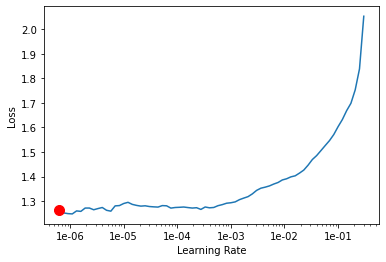

In [ ]:
emotions_learner.unfreeze()
emotions_learner.lr_find()
emotions_learner.recorder.plot(suggestion = True)

In [ ]:
emotions_learner.fit_one_cycle(3, max_lr=slice(1e-06,1.10e-07))

In [ ]:
emotions_learner.freeze_to(-3)
emotions_learner.fit_one_cycle(5, max_lr=slice(1e-06/2, 1.10e-08))

In [ ]:
emotions_256_data = fav.ImageDataBunch.from_folder(emotions_path, ds_tfms=fav.get_transforms(), size=256).normalize(fav.imagenet_stats)
emotions_learner.data = emotions_256_data
emotions_learner.freeze()
emotions_learner.fit_one_cycle(3)

In [ ]:
emotions_learner.unfreeze()
emotions_learner.fit_one_cycle(3, max_lr=slice(3.3e-05, 3.3e-07))

In [ ]:
emotions_learner.freeze_to(-2)
emotions_learner.fit_one_cycle(3)

In [ ]:
emotions_learner.fit_one_cycle(3)

In [ ]:
emotions_learner.freeze_to(-1)
emotions_learner.fit_one_cycle(3)

We trained our model using a resnet34, and feeding it first with 128x128 images, then using the technique mentioned before - resized our images to 256x256 and fed them to the same model. We reached 68% accuracy, which seems fine, but we want to try and make it better.

We have seen that we don't have enough examples for the 'disgust' emotion on people faces. Lets try ignore this label, and see if our model gets better results:

In [ ]:
shutil.rmtree('/tmp/fer_emotions_images/train/disgust')

In [ ]:
emotions128_without_disgust = fav.ImageDataBunch.from_folder(emotions_path, ds_tfms=fav.get_transforms(), size=128).normalize(fav.imagenet_stats)
emotions_learner.data = emotions128_without_disgust

In [ ]:
emotions_learner.unfreeze()
emotions_learner.fit_one_cycle(3)

In [ ]:
emotions_learner.fit_one_cycle(3)

In [ ]:
emotions_learner.fit_one_cycle(5, max_lr=slice(1e-07, 1e-05))

In [ ]:
emotions_learner.freeze_to(-2)
emotions_learner.fit_one_cycle(5)

In [ ]:
emotions256_without_disgust = fav.ImageDataBunch.from_folder(emotions_path, ds_tfms=fav.get_transforms(), size=256).normalize(fav.imagenet_stats)
emotions_learner.data = emotions256_without_disgust
emotions_learner.unfreeze()
emotions_learner.fit_one_cycle(5)

In [ ]:
emotions_learner.export("emotions-70-percent")

We reached 70% accuracy. This is far from perfect, but seems as a good result with the current dataset and techniques.

# Project summary

Let's check our models by classifying our photos


In [ ]:
from shutil import copyfile
os.chdir("/content/gdrive/My Drive/data_science_final_project/")
exact_age_learner = fav.load_learner('.', 'exact-age-utk-6.88-error.pth')
gender_learner = fav.load_learner('.', 'gender-93.7.pth')
age_fair_learner = fav.load_learner('.', 'age-fair-128-58precent.pth')
emotion_learner = fav.load_learner('.', 'emotions-69-percent.pth')
testData = ["idan-test.JPG", "oded-test.JPG" ,"rafael-test.JPG"]

imgs = ["https://i.ibb.co/MpC7dd6/idan-test.jpg", "https://i.ibb.co/xY5D1PH/oded-test.jpg", "https://i.ibb.co/dWB05xf/rafael-test.jpg"]

html = """<HTML>
<body>
<style>{1}</style>
    <h1>Summary test results</h1>
    <table>
      <th>Image</th><th>Exact age</th><th>Age group</th><th>Gender</th><th>Emotion</th>
      {0}
    </table>
</body>
</HTML>"""

style = """
tr { margin: 2% 0; border: 1px solid;}
th { margin: 2% 0; padding: 4px; border: 1px solid;}
td { margin: 2% 0; padding: 10px; text-align: center; border: 1px solid;}
"""
th = "<tr>{0}</tr>"
tr = "<tr>{0}</tr>"
td = "<td>{0}</td>"
tdImg = '<td><img style="width: 100px" src="{0}"/></td>'

htmlTable =[]
for idx, item in enumerate(testData):
  img = fav.open_image(item)
  predGender = gender_learner.predict(img)
  predExactAge = exact_age_learner.predict(img)
  predAgeGroup = age_fair_learner.predict(img)
  predEmotion = emotion_learner.predict(img)
  rowData = [tdImg.format(imgs[idx]), td.format(predExactAge[0]), td.format(predAgeGroup[0]), td.format(predGender[0]), td.format(predEmotion[0])]
  htmlTable.append(tr.format(''.join(rowData)))


html = html.format(''.join(htmlTable),''.join(style))
display(IPython.display.HTML(html))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

As we can see, our model predicted Oded's age pretty precisely (Oded is 23), but failed to predict his gender correctly (Oded is a male). The model also missed with Rafael's age and Idan's as well, but hey, it gave Idan a compliment ;)



## Talking about working
This project was a very intersting and fun way to learn a new field in computers science. We made a big effort to get our models accuracy better. We probably could have reached better results if we had more time - for more training cycles, and more research for fine tuning, but we are happy with those results for now.

As part of this project we dealt with:
* **Cleaning our datasets**. That was not a trivial mission, we couldn't expect it from just looking at the data. We realized how big this challenge is only during the work on our models - by looking at their confussion metrics, and finding that some of the actual labels are wrong.
* **Testing the spliting validation set method**. We came to an understanding after working on UTK dataset that random validaiton set may lead to a wrong model accuracy examination. Hence we tried to check simillar algorithm on FairFace dataset, which is already splited to train/val set. The result was pretty simillar, but we still think that the validation set should be choosen carefuly.
* **Trying multiple metrics to measure accuracy**. We tried at first to train age model by age group label, which gave us a 65% accuracy. In addition we tried to train the model by exact age, by caclucating root_mean_squared_error from the actual age. In that case we achieved 6.88 years standard deviation.

## Improvement Suggestions
* **Cleaning of the data** - the data should have been cleared with more effort, before going to learning stage. Many times we observed that our model was "wrong" but it was due to false tagging. We would invest more time on cleaning and fixing the tagging for next time.
* **Spliting validation set**. We mostly used a random function to split our training/validation set. This may affect model's accuracy.
* **Trying to use other pretrained models** - other sizes of resnet, and other types of neural networks.
* **Working with Google Colab**. If we both had some strong GPUs, we might have chosen to work with our own notebook using git to manage the mutual work and follow changes. Using Colab, whilst giving us the needed GPU to train a model with a big dataset, made our parallel work much more difficult (needed to work on separate notebooks and merge once in a while, and make sure we don't work simultanously).
* **Research other ways to approach this problem**. Our main effort was dealing with the datasets, exploring a few of them, trying, making mistakes, learning from them and moving forward. Hence, we didn't investigate many types of neural networks, or more advanced ways to approach this classification problem. We sticked with the common fastai methods and a resnet because we found that they bring state-of-the-art results, but it can sure help to research how to fine-tune.

## Our thoughts
We made a big progress (from our POV) in the big data and machine learning worlds. We were exposed to many tools and libraries that opened our minds, and showed us how easy is to used data nowdays, aside to how hard it is to use it correctly.
It is a complex task to get a good data and models, but it's not complicated as we though before working on this project.

This project gave us an opportunity to dig into the data science world, a world we wanted to explore, but haven't done it yet. After working on this project, and being introduced to the FastAI library, we feel more confident to start our journey within this industry. We have a lot to learn, but that was a very good point to start.
